# ENEL 645 Data Mining and Machine Learning

W22 Assignment 3 - Option 3
## Implementing a generative adversarial model

### Group 4
- Jawad Aziz Khan
- Sabit Ibn Ali Khan
- Junaed Younus Khan


![Satellite image to Google Map image to Sattleite image again](./media/horseplot.jpg)

# CycleGAN

#### What is a GAN?
GANs are a type of generative model, which means they generate new data instances based on the training data. They can, for example, develop visuals that resemble photos of human faces, despite the fact that the faces do not belong to anybody real.

#### What is a CycleGAN then?
This is a clever type of GAN which specializes in image-to-image translation between different domains. The CyceGAN takes advantage of the fact that a proper translation should be "cycle consistent". Somewhat like using Google Translate to convert an English phrase to French and then convert that back to English, arriving back to the original phrase.

In a CycleGAN the original image (a satellite image of a road) is put through a generator and translated (into a Google Maps image of the same road) and then it is translated again back to its original domain (back to a satellite image). The reconstructed image that is translated back to the original domain is then compared with the actual original image. This still does not require a paired dataset nor supervision to be trained. Some neat applications of this in the realm of computer vision are style transfer, colorization, and upscaling to name a few.

## Imports

Note: please make sure to `pip3 install <name_of_library>` all the python libraries (each separated by spaces) imported below

Run `pip3 install git+https://www.github.com/keras-team/keras-contrib.git` to install the `keras_contrib` library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import sklearn
import random
import os
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from datetime import datetime 
# optional
import urllib
import ssl
import zipfile

# Define the CycleGAN Model Architecture

## The Discriminator
The discriminator simply acts as the classifier in a GAN. Its job is to differentiate between data creatd by the generator and real data. 
The discriminator gets its training data from two sources - real data and fake data made by the generator. 

During training:

1) Fake and real data are classified by the discriminator
2) The loss function penalizes the discriminator for misclassifications
3) The weights are updated through backpropagation

In [2]:
# discriminator model (70x70 patchGAN)
# C64-C128-C256-C512
# After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  
# The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.
def define_discriminator(image_shape):
	# weight initialization
	init = keras.initializers.RandomNormal(stddev=0.02)
	# source image input
	in_image = keras.models.Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = keras.models.Model(in_image, patch_out)
	# compile model
    # The model is trained with a batch size of one image and Adam opt. 
    # with a small learning rate and 0.5 beta. 
    # The loss for the discriminator is weighted by 50% for each model update.
    # This slows down changes to the discriminator relative to the generator model during training.
	model.compile(loss='mse', optimizer=keras.optimizers.adam_v2.Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

## The Generator


The generator, with help from feedback from the discriminator, learns to create fake data with the ultimate goal of making the discriminator classify its data as real. The generator training network has the following componenets: 
1) Putting in random input 
2) A generator network that transforms the random input into an instance of data
3) Discriminator for classification of generated data 
4) Output from discriminator
5) Loss function that penalizes the generator for each time it is unable to fool the discriminator 

The training for the generator is done in the following steps: 
1) Generator output is produced from sampled random noise
2) Get discriminator to decide real or fake for all generator outputs
3) Get loss from the discriminator's classification
4) Use backpropagation on both generator and discriminator and get gradient
5) Use the gradient obtained to change the weight of the generator only

`c7s1-k` denotes a 7×7 Convolution-InstanceNorm-ReLU layer with `k` filters and stride 1. 
`dk` denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with `k` filters and stride 2.
`Rk` denotes a residual block that contains two 3 × 3 convolutional layers and `k` filters
`uk` denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with `k` filters and stride 1/2

The resnet block to be used in the generator contains two 3 × 3 convolutional layers with the same number of filters on both layers.

The network with 6 residual blocks consists of:

`c7s1-64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, c7s1-3`

&nbsp;

The network with 9 residual blocks consists of:

`c7s1-64, d128, d256, R256, R256, R256, R256, R256, R256, R256, R256, R256, u128, u64, c7s1-3`

In [3]:
def resnet_block(n_filters, input_layer):
	init = keras.initializers.RandomNormal(stddev=0.02)
	r = keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	r = InstanceNormalization(axis=-1)(r)
	r = keras.layers.Activation('relu')(r)
	r = keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(r)
	r = InstanceNormalization(axis=-1)(r)
	# concatenate merge channel-wise with input layer
	r = keras.layers.Concatenate()([r, input_layer])
	return r

def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = keras.initializers.RandomNormal(stddev=0.02)
	# image input
	in_image = keras.layers.Input(shape=image_shape)
	# c7s1-64
	g = keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = keras.layers.Activation('relu')(g)
	# d128
	g = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = keras.layers.Activation('relu')(g)
	# d256
	g = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = keras.layers.Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = keras.layers.Activation('relu')(g)
	# u64
	g = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = keras.layers.Activation('relu')(g)
	# c7s1-3
	g = keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = keras.layers.Activation('tanh')(g)
	# define model
	model = keras.models.Model(in_image, out_image)
	return model

## Composite Model

We refer to the Composite Model to indicate the model that we get when we put the generator and discriminator together for training purposes.

In [4]:
# define a composite model for updating generators by adversarial and cycle loss
# We define a composite model that will be used to train each generator separately. 
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    # by keeping other models constant.
    # Remember that we use this same function to train both generators,
    # one generator at a time. 
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False
    
	# adversarial loss
	input_gen = keras.layers.Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = keras.layers.Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
    
	# define model graph
	model = keras.models.Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], optimizer=keras.optimizers.adam_v2.Adam(learning_rate=0.0002, beta_1=0.5))
	return model

## Helper Functions

These are the functions that we used to help us carry out tasks such as loading and generating real samples etc. 

In [27]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = np.load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
# Remember that for real images the label (y) is 1. 
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
# Remember that for fake images the label (y) is 0. 
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = f'{DATASET_NAME}_cyclegan_AtoB_{(step+1):06d}.h5'
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = f'{DATASET_NAME}_cyclegan_BtoA_{(step+1):06d}.h5'
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
	# save plot to file
	filename1 = f'{DATASET_NAME}_{name}_generated_plot_{(step+1):06d}.png'
	plt.savefig(filename1)
	plt.close()

# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images 
# rather than the ones produced by the latest generators.
# Original paper recommended keeping an image buffer that stores 
# the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random.random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = np.random.randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)

# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	#batch size fixed to 1 as suggested in the paper
	n_epochs, n_batch, = epochs, 1  
	n_patch = d_model_A.output_shape[1]
	trainA, trainB = dataset
	# list for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		
        # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		
        # summarize performance
        #Since our batch size =1, the number of iterations would be same as the size of our dataset.
        # In one epoch you'd have iterations equal to the number of images.
        # If you have 100 images then 1 epoch would be 100 iterations
		print(f'{datetime.now()} - e[{int((i+1)/bat_per_epo)}/{n_epochs}] i[{i+1}/{n_steps}], dA:{dA_loss1:.3f},{dA_loss2:.3f} dB:{dB_loss1:.3f},{dB_loss2:.3f} g:{g_loss1:.3f},{g_loss2:.3f}')
		# evaluate the model performance periodically
        # If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % bat_per_epo == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
            # If batch size (total images)=100, model will be saved after 
            # every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

# Train the CycleGAN

## Get the image dataset

First off we will need to download and store an image dataset for the cycleGAN to train on. The dataset can be unpaired and only need to be separated into A or B folders. We will be using the `/datapath` directory as the folder containing our dataset.

Note: although optional, please remember to `pip3 install zipfile` so that the pynotebook can extract the downloaded zip. (or you can setup the dataset folder manually)

In [6]:
# DATASET_NAME = 'monet2photo'
DATASET_NAME = 'maps'

if os.path.isdir('./datapath'):
    print('Directory already "datapath" exists. Moving on')
else:
    os.mkdir('./datapath')
    print('Directory created for datapath')

# needed to bypass the ssl certificate verification fail from the response since the python web client has no cert by default
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

datapath = f'./datapath/{DATASET_NAME}/'
zippath = f"./datapath/{DATASET_NAME}.zip"
if os.path.exists(datapath):
    print(f'Dataset {DATASET_NAME} directory exists. Moving on')
else:
    if os.path.exists(zippath):
        print(f'Dataset {DATASET_NAME} zip file exists. Moving on')
    else:
        print(f'Downloading {DATASET_NAME} dataset zip file.')
        urllib.request.urlretrieve(f"https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/{DATASET_NAME}.zip", zippath, )
    print(f'Zip file size: {os.path.getsize(zippath)/10**6:.2f} MB')
    print(f'Unzipping {DATASET_NAME} dataset to directory.')
    with zipfile.ZipFile(zippath, 'r') as zip_ref:
        zip_ref.extractall('./datapath')
print(f'Directory contents: {os.listdir(datapath)}')


Directory created for datapath
Zip file size: 1476.75 MB
Unzipping maps dataset to directory.
Directory contents: ['test', 'testA', 'testB', 'train', 'trainA', 'trainB', 'val', 'valA', 'valB']


## Load images 

In [7]:
def load_images(path, size=(256,256)):
	data_list = list()
	for filename in os.listdir(path):
		pixels = keras.preprocessing.image.load_img(path + filename, target_size=size)
		pixels = keras.preprocessing.image.img_to_array(pixels)
		data_list.append(pixels)
	return np.asarray(data_list)


Loaded dataA of maps:  (1096, 256, 256, 3)
Loaded dataB of maps:  (1096, 256, 256, 3)


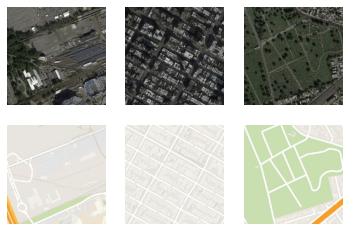

Done loading dataset of 1096 images for both


In [8]:
# load dataset A - Monet paintings
dataA_all = load_images(datapath + 'trainA/')
print(f'Loaded dataA of {DATASET_NAME}: ', dataA_all.shape)


# load dataset B - Photos 
dataB_all = load_images(datapath + 'trainB/')
print(f'Loaded dataB of {DATASET_NAME}: ', dataB_all.shape)

# source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA_all[i].astype('uint8'))
# target images
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB_all[i].astype('uint8'))
plt.show()


# To get a subset of all images, for faster training during demonstration
# dataA = sklearn.utils.resample(dataA_all, replace=False, n_samples=500, random_state=42) 
# dataB = sklearn.utils.resample(dataB_all, replace=False, n_samples=500, random_state=42)  

# load image data
# data = [dataA, dataB] # <- uncomment for faster demo training with smaller resmapled dataset
data = [dataA_all, dataB_all] # <- load full dataset

print(f'Done loading dataset of {len(data[0])} images for both')

## Preprocess dataset

Preprocess data to change input range to values between -1 and 1

This is because the generator uses tanh activation in the output layer and tanh ranges between -1 and 1

In [9]:
def preprocess_data(data):
	# load and unpack compressed arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

## Build the cycleGAN model

In [10]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

# Training

In [28]:
print('Starting CycleGAN training')
start1 = datetime.now() 

train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=5)

stop1 = datetime.now()


#Execution time of the model 
execution_time = stop1-start1
print("Done training. Total execution time is: ", execution_time)

Starting CycleGAN training
2022-03-29 18:50:14.966892 - e[0/5] i[1/5480], dA:0.129,0.128 dB:0.130,0.060 g:11.752,10.795
2022-03-29 18:50:36.551893 - e[0/5] i[2/5480], dA:0.119,0.201 dB:0.125,0.049 g:14.809,13.309
2022-03-29 18:50:58.126892 - e[0/5] i[3/5480], dA:0.091,0.038 dB:0.138,0.038 g:15.106,14.696
2022-03-29 18:51:19.326892 - e[0/5] i[4/5480], dA:0.241,0.027 dB:0.080,0.073 g:10.941,10.648
2022-03-29 18:51:43.033448 - e[0/5] i[5/5480], dA:0.078,0.061 dB:0.130,0.111 g:15.258,14.692
2022-03-29 18:52:05.905448 - e[0/5] i[6/5480], dA:0.088,0.046 dB:0.119,0.145 g:11.777,10.806
2022-03-29 18:52:29.556591 - e[0/5] i[7/5480], dA:0.189,0.177 dB:0.193,0.059 g:13.350,10.753
2022-03-29 18:52:53.058590 - e[0/5] i[8/5480], dA:0.074,0.142 dB:0.176,0.045 g:14.870,13.206
2022-03-29 18:53:16.471590 - e[0/5] i[9/5480], dA:0.086,0.075 dB:0.129,0.111 g:13.630,12.634
2022-03-29 18:53:38.292870 - e[0/5] i[10/5480], dA:0.251,0.049 dB:0.071,0.061 g:14.305,13.178
2022-03-29 18:53:59.797870 - e[0/5] i[11/5

# Testing

In [29]:
def select_sample(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	return X

def show_plot(imagesX, imagesY1, imagesY2):
	images = np.vstack((imagesX, imagesY1, imagesY2))
	titles = ['Original', 'Generated', 'Reconstructed']
	images = (images + 1) / 2.0

	for i in range(len(images)):
		plt.subplot(1, len(images), 1 + i)
		plt.axis('off')
		plt.imshow(images[i])
		plt.title(titles[i])
	plt.show()

In [31]:
# load dataset
# and set random state for reproducible results
A_data = sklearn.utils.resample(dataA_all, replace=False, n_samples=50, random_state=42) 
B_data = sklearn.utils.resample(dataB_all, replace=False, n_samples=50, random_state=42)

# normalize
A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

# load the models
custom_objs = {'InstanceNormalization': InstanceNormalization}
model_AtoB = keras.models.load_model('maps_cyclegan_AtoB_005480.h5', custom_objs)
model_BtoA = keras.models.load_model('maps_cyclegan_BtoA_005480.h5', custom_objs)

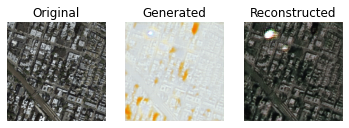

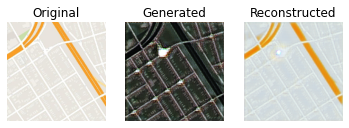

In [32]:
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

# Loading and then testing the model

The model is loaded up from the `h5` file and tested on an image from outside the dataset

In [1]:
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

### Downloading the model (optional)

In [1]:
import urllib
import ssl

# needed to bypass the ssl certificate verification fail from the response since the python web client has no cert by default
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context
modelApath = './maps_cyclegan_AtoB_005480.h5'
modelBpath = './maps_cyclegan_BtoA_005480.h5'
urllib.request.urlretrieve('https://github.com/JunaedYounusKhan51/ENEL645/blob/main/Assignment-3/maps_cyclegan_AtoB_005480.h5?raw=true', modelApath, )
urllib.request.urlretrieve('https://github.com/JunaedYounusKhan51/ENEL645/blob/main/Assignment-3/maps_cyclegan_BtoA_005480.h5?raw=true', modelBpath, )

('./maps_cyclegan_B.h5', <http.client.HTTPMessage at 0x7f893305c410>)

In [2]:
def show_plot(imagesX, imagesY1, imagesY2):
	images = np.vstack((imagesX, imagesY1, imagesY2))
	titles = ['Original', 'Generated', 'Reconstructed']
	images = (images + 1) / 2.0

	for i in range(len(images)):
		plt.subplot(1, len(images), 1 + i)
		plt.axis('off')
		plt.imshow(images[i])
		plt.title(titles[i])
	plt.show()

In [5]:
# load the models
modelApath = './maps_cyclegan_AtoB_005480.h5'
modelBpath = './maps_cyclegan_BtoA_005480.h5'

custom_objs = {'InstanceNormalization': InstanceNormalization}
model_AtoB = keras.models.load_model(modelApath, custom_objs)
model_BtoA = keras.models.load_model(modelBpath, custom_objs)

print('Models loaded')

Models loaded


# Test on a custom image

The model is tested with a new image not seen in training.

The `TEST_IMG_PATH` constant can be changed to any other image stored locally.

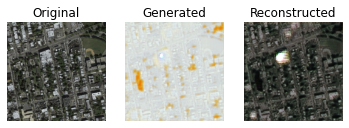

In [12]:
TEST_IMG_PATH = 'datapath/maps/testA/1_A.jpg'
test_image = keras.preprocessing.image.load_img(TEST_IMG_PATH)
test_image = keras.preprocessing.image.img_to_array(test_image)
test_image = keras.preprocessing.image.smart_resize(test_image, (256, 256), interpolation='bilinear')
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

# plot A->B->A
monet_generated = model_AtoB.predict(test_image_input)
photo_reconstructed = model_BtoA.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)

### Now the other way around

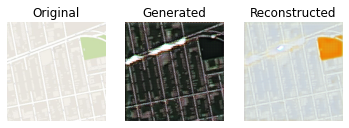

In [13]:
TEST_IMG_PATH = 'datapath/maps/testB/1_B.jpg'
test_image = keras.preprocessing.image.load_img(TEST_IMG_PATH)
test_image = keras.preprocessing.image.img_to_array(test_image)
test_image = keras.preprocessing.image.smart_resize(test_image, (256, 256), interpolation='bilinear')
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5

# plot B->A->B
monet_generated = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(monet_generated)
show_plot(test_image_input, monet_generated, photo_reconstructed)